This dataset was created by scraping jobs from Glassdoor with the "Selenium" library. You can check scrapper code [here](https://github.com/arapfaik/scraping-glassdoor-selenium) and also dataset available on [Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/data-science-job-posting-on-glassdoor/data).

In this notebook, I cleaned the data, did some feature extractions and visualizations. Detailed information about the topics is given under their own headings.

**📜 Table Of Contents:**
* [DATA CLEANING](#section-one)
* [FEATURE EXTRACTION](#section-two)
* [VISUALIZATION](#section-three)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df_orginal = pd.read_csv("/content/Uncleaned_DS_jobs.csv")
df = df_orginal.copy()
df.head()

,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY","New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,"EmblemHealth, UnitedHealth Group, Aetna"
1,1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),-1
2,2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA","Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$137K-$171K (Glassdoor est.),JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON\n3.5,"Newton, MA","Bad Ragaz, Switzerland",501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),"MKS Instruments, Pfeiffer Vacuum, Agilent Tech..."
4,4,Data Scientist,$137K-$171K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              672 non-null    int64  
 1   Job Title          672 non-null    object 
 2   Salary Estimate    672 non-null    object 
 3   Job Description    672 non-null    object 
 4   Rating             672 non-null    float64
 5   Company Name       672 non-null    object 
 6   Location           672 non-null    object 
 7   Headquarters       672 non-null    object 
 8   Size               672 non-null    object 
 9   Founded            672 non-null    int64  
 10  Type of ownership  672 non-null    object 
 11  Industry           672 non-null    object 
 12  Sector             672 non-null    object 
 13  Revenue            672 non-null    object 
 14  Competitors        672 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 78.9+ KB


In [ ]:
print(f'Shape     : {df.shape}\n'
      f'Size      : {df.size}\n'
      f'Dimension : {df.ndim}')

Shape     : (672, 15)
Size      : 10080
Dimension : 2


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,672.0,335.500000,194.133974,0.0,167.75,335.5,503.25,671.0
Rating,672.0,3.518601,1.410329,-1.0,3.30,3.8,4.30,5.0
Founded,672.0,1635.529762,756.746640,-1.0,1917.75,1995.0,2009.00,2019.0


<a id="section-one"></a>
# **DATA CLEANING**
1. Rename columns to lowercase and replace spaces with underscores.
2. Drop the unnecessary "index" column.
    - After removing the extra "index" column, 10 duplicated data appeared.
3. Standardize job titles
    - e.g. Junior to Jr.
4. Negative Values:
    - In web scraping code, the value is assigned to -1 if it cannot be scrapped.
    - Therefore, some columns have at least one -1 value.
        * 'Rating', 'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors'
    - As a result, -1's will be replaced with 'can't scrapped'.
5. Remove the parentheses ((Glassdoor est.)) and the letter "K" in the "**Estimated Salary**" column. After that rename the column to “Salary Estimate (K)”.
6. In "**Job Description**", replace the escape characters "\n" with commas.
7. Remove rating scores from "**Company Name**".
8. Replace the words “to” and “employee” in the “**size**” column and rename it to “size_employee”.
    - e.g. 1001-5000
9. Remove the "Dollar" sign and parentheses ((USD)) from the "**Revenue**" section.

In [ ]:
# Column Names
df.columns = [x.lower().replace(" ", "_") for x in df.columns]


In [ ]:
# Drop Index
df.drop(['index'], inplace=True, axis=1)

df.drop_duplicates(inplace=True)

In [ ]:
# -1
for col in df.columns[df.isin([-1, "-1"]).any()].tolist():
    df[col] = np.where(df[col] == -1.0, "can't scrapped / unknown", df[col])
    df[col] = np.where(df[col] == '-1', "can't scrapped / unknown", df[col])


In [ ]:
# Job Title
df['job_title'] = df['job_title'].replace({'Junior ': 'Jr. ',
                                           'Senior ': 'Sr. ',
                                           'Sr ': 'Sr. '}, regex=True)

In [ ]:
# Salary Estimate
df.rename(columns={"salary_estimate": "salary_estimate_($k)"}, inplace=True)


df['salary_estimate_($k)'] = df['salary_estimate_($k)'].replace({'\$': '',
                                                                 'K': '',
                                                                 ' \(Glassdoor est.\)': '',
                                                                 '\(Employer est.\)': ''}, regex=True)

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\('
<>:8: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\('
<>:8: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-1204537163.py:5: SyntaxWarning: invalid escape sequence '\$'
  df['salary_estimate_($k)'] = df['salary_estimate_($k)'].replace({'\$': '',
/tmp/ipython-input-1204537163.py:7: SyntaxWarning: invalid escape sequence '\('
  ' \(Glassdoor est.\)': '',
/tmp/ipython-input-1204537163.py:8: SyntaxWarning: invalid escape sequence '\('
  '\(Employer est.\)': ''}, regex=True)


In [ ]:
# Job Description
df['job_description'] = df['job_description'].replace({'\n\n':' ',
                                                       '\n':' '}, regex=True)

In [ ]:
# Company Name
df['company_name'] = df['company_name'].apply(lambda x: x.split('\n')[0])

In [ ]:
# Size
df.rename(columns={"size": "size_(employee)"}, inplace=True)

df['size_(employee)'] = df['size_(employee)'].replace({' to ': '-',
                                                       ' employees': ''}, regex=True)

In [ ]:
#%%
# Revenue
df.rename(columns={"revenue": "revenue_($)"}, inplace=True)

df['revenue_($)'] = df['revenue_($)'].replace({'\$': '',
                                               ' \(USD\)': ''}, regex=True)

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-4245000537.py:5: SyntaxWarning: invalid escape sequence '\$'
  df['revenue_($)'] = df['revenue_($)'].replace({'\$': '',
/tmp/ipython-input-4245000537.py:6: SyntaxWarning: invalid escape sequence '\('
  ' \(USD\)': ''}, regex=True)


<a id="section-two"></a>
# **Feature Extraction**

1. Extract the minimum, maximum and average salaries in the "Salary Estimate" column.
2. Categorize the rating based on information from Glassdoor below:
    * 0.00 - 1.50 Employees are "Very Dissatisfied"
    * 1.51 - 2.50 Employees are "Dissatisfied"
    * 2.51 - 3.50 Employees say it's "OK"
    * 3.51 - 4.00 Employees are "Satisfied"
    * 4.01 - 5.00 Employees are "Very Satisfied"
3. Create new columns containing cities and states from the "Location" column.
    * The new "location_city" columns have some non-city variables. Replace these with na.
    * Standardize state abbreviation.
4. Create new columns named "headquarters_country", "headquarters_city", "headquarters_state".
    * If the headquarters is not located in America:
        - Paris, None, France
    * On the other hand, if the headquarters is located in America:
        - Dallas, TX, America
5. Calculating the age of the company
6. Get the skills from the "Job Description" column.
    * e.g. Assign 1 to the new "Python" column if Python is mentioned in the sentences, 0 otherwise.

In [ ]:
# Min, Max and Avg Salary
df[['min_salary', 'max_salary']] = df['salary_estimate_($k)'].apply(lambda x: pd.Series(x.split('-'))).astype(int)
df['avg_salary'] = df.apply(lambda x: int((x['min_salary'] + x['max_salary']) / 2), axis=1)

In [ ]:
# Rating Categorization
def rating_categorizer(value):
    if value == "can't scrapped / unknown":
        return value
    else:
        value = float(value)
        if 0.0 <= value <= 1.50:
            return "Very Dissatisfied"
        elif 1.51 <= value <= 2.50:
            return "Dissatisfied"
        elif 2.51 <= value <= 3.50:
            return "OK"
        elif 3.51 <= value <= 4:
            return "Satisfied"
        else:
            return "Very Satisfied"

df["ratings_categoric"] = df['rating'].apply(lambda x: rating_categorizer(x))

In [ ]:
# Location city and state of company
df['location_city'] = df['location'].apply(lambda x: x.split(",")[0])
df['location_state_abbr'] = df['location'].apply(lambda x: x.split(",")[-1])

# Change non-cities in laction_city to "na"
df['location_city'] = df['location_city'].replace({'Utah': 'N/a',
                                                   'New Jersey': 'N/a',
                                                   'Texas': 'N/a',
                                                   'California': 'N/a',
                                                   'Remote': 'N/a',
                                                   'United States': 'N/a'}, regex=True)

# Standardization of abbreviations
df['location_state_abbr'] = df['location_state_abbr'].replace({'Utah': 'UT',
                                                               'New Jersey': 'NJ',
                                                               'Texas': 'TX',
                                                               'California': 'CA',
                                                               'Remote': 'N/a',
                                                               'United States': 'N/a'}, regex=True)

In [ ]:
# The number 3 was chosen because one of the headquarters is "New York, 061".
def hq_state_city_country(values, type=None):
    state = values.split(", ")[-1]
    city = values.split(", ")[0]

    if "unknown" in values:
        return values
    elif len(state) > 3:
        if type=='country':
            return state
        elif type=='city':
            return city
        else:
            return "None"
    else:
        if type=="city":
            return city
        elif type=='state':
            return state
        else:
            return "America"


df['headquarters_city'] = df['headquarters'].apply(lambda x: hq_state_city_country(x, "city"))
df['headquarters_state'] = df['headquarters'].apply(lambda x: hq_state_city_country(x, 'state'))
df['headquarters_country'] = df['headquarters'].apply(lambda x: hq_state_city_country(x, 'country'))

In [ ]:
# Company age
df['company_age'] = df['founded'].apply(lambda x: x if x == "can't scrapped / unknown" else datetime.now().year - int(x))

In [ ]:
# "excel" --> " excel " because excellent
# "aws" --> " aws" because laws

r_cases = [' r ', ' r,', ' r)']
skills = ['python', ' excel ', 'hadoop', 'spark', ' aws',
          'tableau', 'big data', 'sql', 'c++',
          'java', 'scala']

for skill in skills:
    df[skill.strip()] = df['job_description'].apply(lambda x: 1 if skill in x.lower() else 0)

df['r'] = df['job_description'].apply(lambda x: 1 if any(r in x.lower() for r in r_cases) else 0)

<a id="section-three"></a>
# **VISUALIZATION**

**Plotly** is an open-source Python graphing library that is great for building beautiful and interactive visualizations. Therefore, I will use the Plotly library.

In [ ]:
fig = go.Figure(data=[go.Pie(labels=df['ratings_categoric'].value_counts().index,
                             values=df['ratings_categoric'].value_counts(),
                             textinfo='label+percent')])

fig.update_layout(title="Rating",
                  legend=dict(orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1,
                              font_size=14),
                 margin=dict(t=100, b=0, l=0, r=0))

fig.update_traces(hoverinfo='label+value',
                  textfont_size=15,
                  marker=dict(colors=px.colors.qualitative.Set3))

fig.show()

In [ ]:
fig = go.Figure(data=[go.Pie(labels=df['size_(employee)'].value_counts().index,
                             values =df['size_(employee)'].value_counts(),
                             textinfo='label+percent',
                             hole=.2)])

fig.update_layout(title="Companies Sizes (Employee)",
                  legend=dict(yanchor="bottom",
                              y=0.3,
                              xanchor="left",
                              x=-0.2,
                              font_size=14),
                  margin=dict(t=100, b=0, l=0, r=0))

fig.show()

In [ ]:
size_order = ["can't scrapped / unknown", 'Unknown', '1-50',
              '51-200', '201-500', '501-1000', '1001-5000',
              '5001-10000', '10000+']

fig = px.bar(df,
             x="size_(employee)",
             labels={'size_(employee)': 'Company Size (Employee)',
                     'count': '# Company'},
             color='size_(employee)',
             color_discrete_sequence=px.colors.qualitative.Plotly,
             category_orders={'size_(employee)': size_order,
                              'Company Size (Employee)': size_order})

fig.update_layout(title="Company Size (Employee)",
                  title_x=0.5)

fig.update_xaxes(ticks="outside",
                 tickcolor="white",
                 ticklen=10)

fig.show()

In [ ]:
fig = go.Figure([go.Bar(x=df['revenue_($)'].value_counts().index,
                        y=df['revenue_($)'].value_counts())])

fig.update_layout(title="Number of Companies by revenue",
                  title_x=0.5)

fig.update_traces(marker_color=px.colors.qualitative.Alphabet,
                  marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5,
                  opacity=0.6)
fig.show()

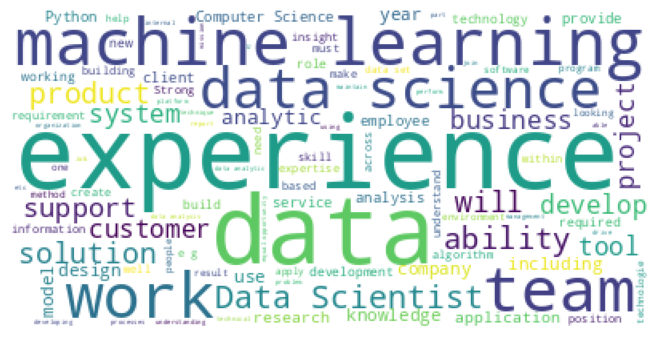

In [ ]:
Stopwords = set(STOPWORDS)
text = " ".join(review for review in df.job_description)

wordcloud = WordCloud(max_words=100,
                      background_color='white',
                      stopwords=Stopwords).generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()